In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import time
from math import pi, sinh, sin,sqrt,floor
import pandas as pd
from functools import reduce

%matplotlib inline
# from sympy import symbols, sin, sinh, pi, latex  - commented as other functions reading sin, etc. as symbols when 
# calculating


# Graphically compare numerical and analytical along middle of plate


In [2]:
def NumericalvsAnalytical(Tfv,Tan,Nx):
    
    #get cells midway through element in x direction along y = Lx/2
    cells = np.arange(floor(Nx/2)+1, Nx*(Ny+.5)-1,Nx) 
    #get T at each of these cells
    Tmidfv = [Tfv[floor(i)] for i in cells]
    Tmidan = [Tan[floor(i)] for i in cells]
    
    y = np.linspace(0,Nx,len(Tmidfv))
    
    #plot analytical vs numerical
    plt.figure()
    plt.plot(y, Tmidan, 'k', y, Tmidfv, 'kx', markersize = 5)
    plt.title('Temperature along y=Lx/2 for analytical and numerical solution', fontsize = 12, weight = 600)
    plt.xlabel('Cells along y=Lx/2', fontsize = 12, weight = 600)
    plt.ylabel('Temperature', fontsize = 12, weight = 600)
    plt.legend(['analytical', 'numerical'])
    plt.savefig('midplate80.png')

    plt.show()
    


    



# Analytical Solution


In [3]:
def AnalyticalHeatConduction(Tt,Tb,Tl,Tr,Lx,Ly,dx,dy,Nx,Ny):
    #homogeneous boundary conditions
    #Tt,Tb,Tl,Tr: top, bottom, left and right temperatures i.e. boundary conditions
    #Lx, Ly: dimensions of element(length and width)
    #dx, dy: mesh size of numerical solution (evaluate analytical at these points for comparison)
    #M: no. of cells i.e. no. of T's that will be evaluated
    
    M = int(Nx*Ny)
    #initialise temperature
    phi = np.zeros((M,1)) #phi is dimensionless temperature used for conveniance
    T = np.zeros((M,))
    
    #x coordinates
    x = np.arange(dx/2, Lx, dx)
    #y coordinates
    y = np.arange(dy/2, Ly, dy)
    celli = 0 #start at cell 0
    #start row
    for j in y:
        #find for each cell along row
        for i in x:
            #compute series expansion to 50 terms
            for n in range(1,100,1):
                #phi[celli] += (2*sin(n*pi*i/Lx)*(1-(-1)**n)/(n*pi))*(sinh(n*pi*j/Lx)/sinh(n*pi*Ly/Lx)) #odd series 
                #analytical solution
                phi[celli] += (2*sin(n*pi*i/Lx)*(1+(-1)**(n+1))/(n*pi))*(sinh(n*pi*j/Lx)/sinh(n*pi*Ly/Lx))#all series 
                #analytical solution used for better accuracy than odd series
            #final phi found now find temperature
            T[celli] = phi[celli]*(Tt-Tb)+Tb
            #move to next cell
            celli += 1
    
#     fig, ax = plt.subplots()

#     ax.set_xlabel('Lx (m)', rotation=0, size=12)
#     ax.set_ylabel('Ly (m)', rotation=90, size=12)
#     colorinterpolation = 50
#     colorMap = plt.cm.jet
#     X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
#     T_anplot = np.reshape(T, (Nx, Ny))

#     plt.contour(X,Y,T_anplot,colorinterpolation,cmap=colorMap)
#     cbar = plt.colorbar()
#     cbar.ax.get_yaxis().labelpad = 20
#     cbar.ax.set_ylabel('Temperature (C)', rotation=270, size=12)

#     plt.savefig('Tan')

#     plt.show()


    return T

       #227 is maximum number of terms before math error occurs in calculation 

#     Nicely display Analytical Equation

In [4]:
# n = symbols('n')
# Lx= symbols('Lx')
# i = symbols('i')
# j = symbols('j')
# Ly= symbols('Ly')
# equation = "(2*sin(n*pi*i/Lx)*(1+(-1)**(n+1))/(n*pi))*(sinh(n*pi*j/Lx)/sinh(n*pi*Ly/Lx))"

# print(latex(eval(equation)))

$$ \frac{2 \left(\left(-1\right)^{n + 1} + 1\right) \sin{\left(\frac{\pi i n}{Lx} \right)} \sinh{\left(\frac{\pi j n}{Lx} \right)}}{\pi n \sinh{\left(\frac{\pi Ly n}{Lx} \right)}}
 $$


# FV steady state heat conduction normal implementation


In [5]:
def Temperature(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #Calculate coefficients
    #east and west face coefficients equal i.e. along x direction
    ax = k*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = k*dx/dy
    
    ap = -2*(ax+ay)
    
#     print(ax,ay,ap)
    # total number of cells
    M = Nx*Ny
    M = int(M)
    #Initialise temperature vector
    T = np.zeros((M, 1))
    
    #Initialise source vector
    b = np.zeros((M, 1))
    
    #Initialise coefficient matrix
    A = np.zeros((M, M))
    #sparse matrix
    #A = csr_matrix((M, M))
    
    #get indices of corner cells
    botright = Nx-1
    topleft = Nx*(Ny-1)
    topright = Nx*Ny-1
    
    #QUESTION: IS IT BETTER TO COMPUTE INDICES OF BOTTOM RIGHT, BOTTOM LEFT, LEFT, RIGHT ETC AND STORE AS VARIABLES?
    #Loop through each cell i
    for i in range(0, M):
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tl
            #insert coefficients 
            A[i][i] = ap-ax-ay #centre
            A[i][i+1] = ax #east
            A[i][i+Nx] = ay #north
            
        #bottom right
        elif i == botright:
            #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tr
            #insert coefficients
            A[i][i] = ap-ax-ay #centre
            A[i][i-1] = ax #west
            A[i][i+Nx] = ay #north
            
        #top left
        elif i == topleft:
            #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tl
            #insert coefficients
            A[i][i] = ap-ax-ay #centre
            A[i][i+1] = ax #east
            A[i][i-Nx] = ay #south
        
        #top right
        elif i == topright:
            #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tr
            #insert coefficients
            A[i][i] = ap-ax-ay #centre
            A[i][i-1] = ax #west
            A[i][i-Nx] = ay #south
        
        #SIDES
        #bottom
        elif 0 < i < botright:
            #compute constant for this equation
            b[i] = -2*ay*Tb
            #insert coefficients
            A[i][i] = ap-ay #centre
            A[i][i+Nx] = ay #north
            A[i][i+1] = ax #east
            A[i][i-1] = ax #west
        
        #top
        elif topleft < i < topright:
            #compute constant for this equation
            b[i] = -2*ay*Tt
            #insert coefficients
            A[i][i] = ap-ay #centre
            A[i][i-Nx] = ay #south
            A[i][i+1] = ax #east
            A[i][i-1] = ax #west
        
        #left
        elif i in range(Nx,topleft,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tl
            #insert coefficients
            A[i][i] = ap-ax #centre
            A[i][i-Nx] = ay #south
            A[i][i+1] = ax #east
            A[i][i+Nx] = ay #north
            
        #right
        elif i in range(botright+Nx,topright,Nx):
            
            #compute constant for this equation
            b[i] = -2*ax*Tr
            #insert coefficients
            A[i][i] = ap -ax#centre
            A[i][i-Nx] = ay #south
            A[i][i-1] = ax #west
            A[i][i+Nx] = ay #north
        else:
            b[i] = 0
            A[i][i] = ap #centre
            A[i][i-Nx] = ay #south
            A[i][i-1] = ax #west
            A[i][i+Nx] = ay #north
            A[i][i+1] = ax #east
    
    t = time.time()

    T = np.linalg.solve(A,b)
#     t_solve = time.time()
    print('Time to solve the linear system = ', time.time() - t)
#     print(t_solve)
    
    colorinterpolation = 50
    colorMap = plt.cm.jet

    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    T_plot = np.reshape(T, (Nx, Ny))
    plt.contourf(X,Y,T_plot,colorinterpolation,cmap=colorMap)
    plt.colorbar()
    plt.show()
    return T

Time to solve the linear system =  0.30876684188842773


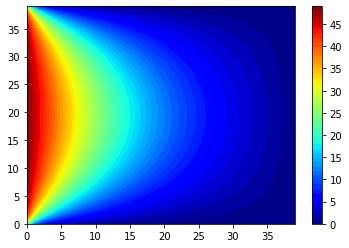

In [6]:
Lx = 1
Ly = 1
Nx = 40 #when Nx and Ny = 164 the best convergence is achieved
Ny = 40
k = 1
Tl = 50
Tr = 0
Tt = 0
Tb = 0
T = Temperature(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb)


# FV steady state heat conduction with scipy implementation

In [7]:
def FVheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #Calculate coefficients
    #east and west face coefficients equal i.e. along x direction
    ax = k*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = k*dx/dy
    
    ap = -2*(ax+ay)
    # total number of cells
    M = Nx*Ny
    M = int(M)
    
    
    #Initialise temperature vector
    Tfv = np.zeros((M, 1))
    
    #Initialise source vector
    b = np.zeros((M, 1))
    
    # 3 coeffs on each corner + 4 coeffs on each cell attached to a side
    #+ 5 coeffs on each internal cell
    internalandcorner = 3*4+5*(Nx-2)*(Ny-2)
    sides =  4*(2*Nx+2*Ny-8)
    numNonZeros = internalandcorner+sides
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))

    
    #get indices of corner cells
    botright = Nx-1
    topleft = Nx*(Ny-1)
    topright = Nx*Ny-1
    
    #Loop through each cell i
    coeffi=0
    for i in range(0, M):
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
            
        #bottom right
        elif i == botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
        #top left
        elif i == topleft:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top right
        elif i == topright:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #SIDES
        #bottom
        elif 0 < i < botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top
        elif topleft < i < topright:
            #compute constant for this equation
            b[i] = -2*ay*Tt
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficien
        #left
        elif i in range(Nx,topleft,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        #right
        elif i in range(botright+Nx,topright,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tr
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
        else:
            b[i] = 0
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = ap 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
    

    #create sparse coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(M, M))

    t = time.time()
    #solve set of simultaneous equations
    Tfv = scipy.sparse.linalg.spsolve(A, b)
    print('Time to solve the linear system = ', time.time() - t)
        
    T_an = AnalyticalHeatConduction(Tt,Tb,Tl,Tr,Lx,Ly,Lx/Nx,Ly/Ny,Nx,Ny)

    #ERROR
    mse = ((T_an - Tfv)**2).mean(axis=0)
    l2_norm = np.linalg.norm(abs(T_an-Tfv))
    inf_norm = np.linalg.norm(abs(T_an-Tfv),np.inf) 
    
    #VISUALISATION
    plt.figure()
    NumericalvsAnalytical(Tfv,T_an,Nx)
    
    colorinterpolation = 50
    colorMap = plt.cm.jet

    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    T_fvplot = np.reshape(Tfv, (Nx, Ny))
    T_anplot = np.reshape(T_an, (Nx, Ny))
    
    plt.figure()
#     plt.contourf(X, Y, T_plot, cmap='inferno')
    plt.contourf(X,Y,T_fvplot,cmap='inferno')
    plt.colorbar()
    plt.title('Numerical',fontsize= 13)
    plt.savefig("SSTemp.png")
    plt.show()
    plt.figure()
    plt.contourf(X,Y,T_anplot,cmap='inferno')
    plt.title('Analytical',fontsize= 13)
    plt.colorbar()
    plt.savefig("AnTemp.png")
    plt.show()
    plt.figure()
    plt.contour(X,Y,abs(T_anplot-T_fvplot),cmap='inferno')
    plt.colorbar()
    plt.show()
    plt.contour
        

    return Tfv,mse,l2_norm,inf_norm

Time to solve the linear system =  0.0032126903533935547


<Figure size 432x288 with 0 Axes>

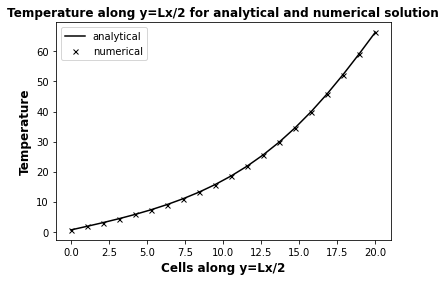

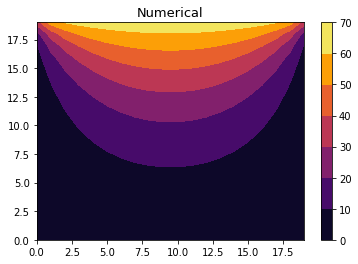

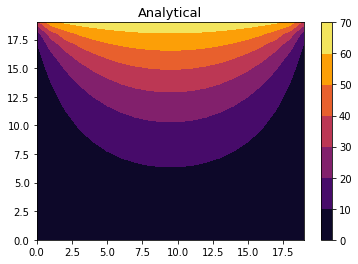

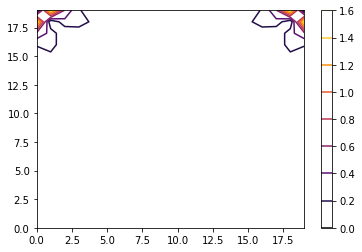

In [8]:
#Define inputs

Lx = 1
Ly = 1
Nx = 20#when Nx and Ny = 164 the best convergence is achieved
Ny = 20
k = 1
Tl = 0
Tr = 0
Tt = 70
Tb = 0

Tfv,mse,l2_norm,inf_norm = FVheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb)



This version of FV heat conduction just computes numerical solution and does no error analysis in comparison with analytical solutioin

In [9]:
def JustFVheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #Calculate coefficients
    #east and west face coefficients equal i.e. along x direction
    ax = k*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = k*dx/dy
    
    ap = -2*(ax+ay)
    # total number of cells
    M = Nx*Ny
    M = int(M)
    
    
    #Initialise temperature vector
    Tfv = np.zeros((M, 1))
    
    #Initialise source vector
    b = np.zeros((M, 1))
    
    # 3 coeffs on each corner + 4 coeffs on each cell attached to a side
    #+ 5 coeffs on each internal cell
    internalandcorner = 3*4+5*(Nx-2)*(Ny-2)
    sides =  4*(2*Nx+2*Ny-8)
    numNonZeros = internalandcorner+sides
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))

    
    #get indices of corner cells
    botright = Nx-1
    topleft = Nx*(Ny-1)
    topright = Nx*Ny-1
    
    #Loop through each cell i
    coeffi=0
    for i in range(0, M):
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
            
        #bottom right
        elif i == botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
        #top left
        elif i == topleft:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top right
        elif i == topright:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #SIDES
        #bottom
        elif 0 < i < botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top
        elif topleft < i < topright:
            #compute constant for this equation
            b[i] = -2*ay*Tt
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficien
        #left
        elif i in range(Nx,topleft,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        #right
        elif i in range(botright+Nx,topright,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tr
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
        else:
            b[i] = 0
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = ap 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
    

    #create sparse coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(M, M))

    t = time.time()
    #solve set of simultaneous equations
    Tfv = scipy.sparse.linalg.spsolve(A, b)
    print('Time to solve the linear system = ', time.time() - t)
        

    
    
    #VISUALISATION
    plt.figure()
    
    colorinterpolation = 50
    colorMap = plt.cm.jet

    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    T_fvplot = np.reshape(Tfv, (Nx, Ny))
    
    plt.figure()
#     plt.contourf(X, Y, T_plot, cmap='inferno')
    plt.contourf(X,Y,T_fvplot,cmap='inferno')
    plt.colorbar()
    plt.title('Numerical',fontsize= 13)
    

    return Tfv



FV steady state heat conduction tested vs analytical solution and compared graphically

# Cell to Test Functions


Time to solve the linear system =  0.010350704193115234


<Figure size 432x288 with 0 Axes>

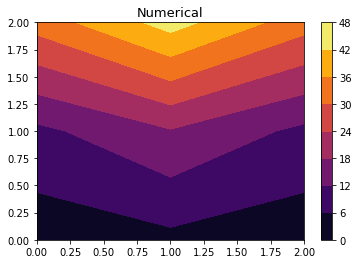

In [10]:
#Define inputs

Lx = 1
Ly = 1
Nx = 3 #when Nx and Ny = 164 the best convergence is achieved
Ny = 3
k = 1
Tl = 0
Tr = 0
Tt = 70
Tb = 0

Tfv = JustFVheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb)



# Analysing 2nd Order Convergence

Mean squared error is found for 4 meshes, each time the no. of cells doubling in each direction i.e. the cell size is being halved, and this error is plotted on a log-log plot to demonstrate second order convergence of the solution

Time to solve the linear system =  0.0005071163177490234


<Figure size 432x288 with 0 Axes>

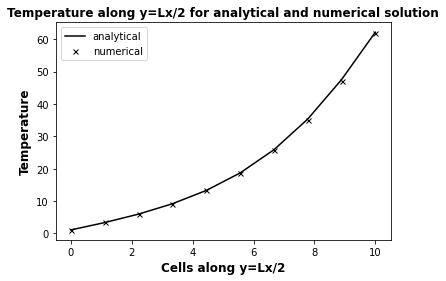

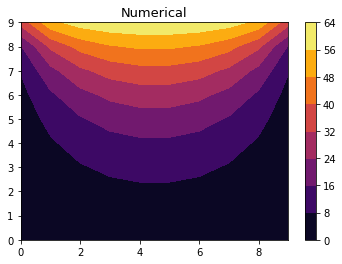

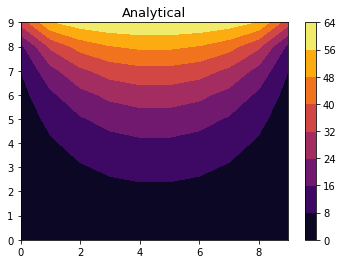

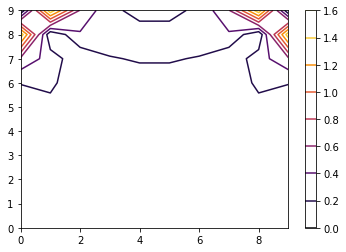

Time to solve the linear system =  0.007464408874511719


<Figure size 432x288 with 0 Axes>

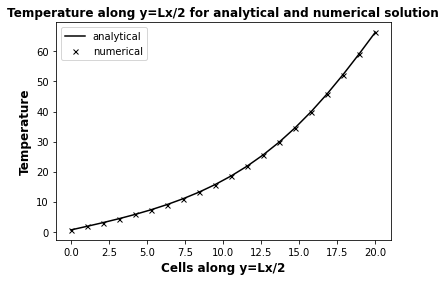

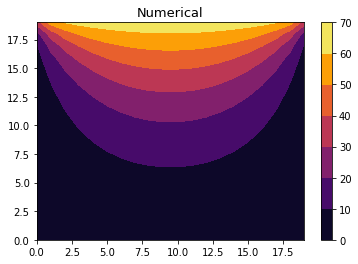

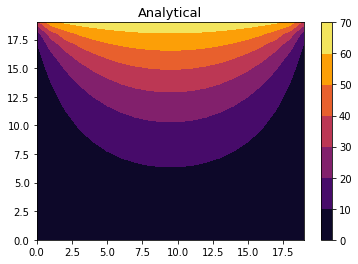

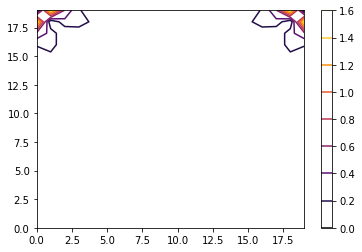

Time to solve the linear system =  0.0077517032623291016


<Figure size 432x288 with 0 Axes>

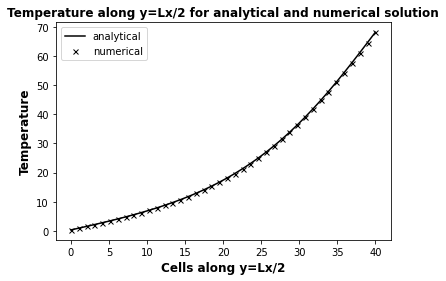

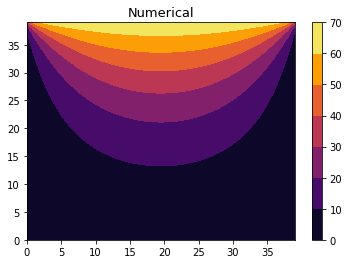

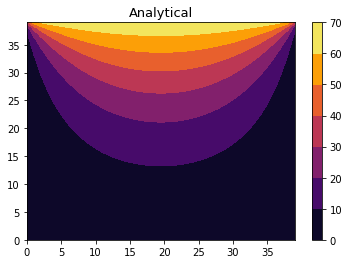

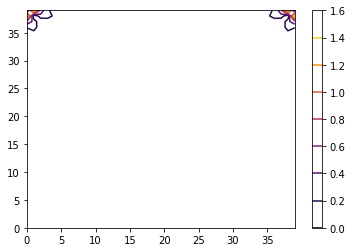

Time to solve the linear system =  0.05112051963806152


<Figure size 432x288 with 0 Axes>

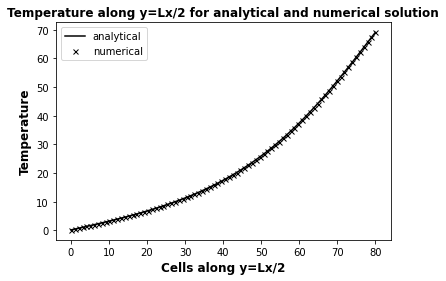

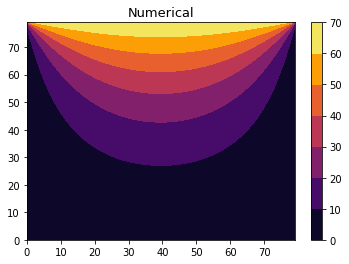

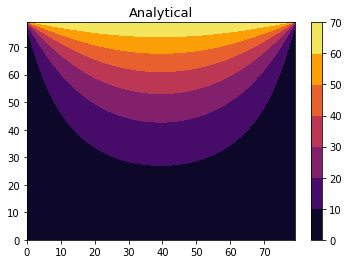

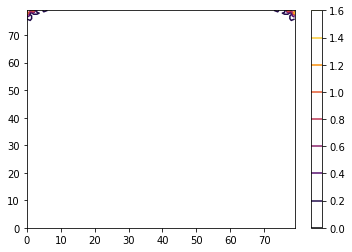

[3.50880522 3.50523925 3.47902242 3.69154052]
[0.12311714 0.03071676 0.00756475 0.00212929]
[1.54300255 1.5356386  1.53488772 1.54850483]
[0. 0. 0. 0.]


In [11]:
mse = np.zeros(4)
# Tfv_conv = np.zeros(4)
# Tan_conv = np.zeros(4)
l2_norm = np.zeros(4)
inf_norm = np.zeros(4)
python_norm = np.zeros(4)

Nx = 10 #final Nx and Ny = 160
Ny= 10
for i in range(0,4):
    
    _,mse[i],l2_norm[i], inf_norm[i] = FVheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb)
    Nx=Nx*2
    Ny=Ny*2
print(l2_norm)
print(mse)
print(inf_norm)
print(python_norm)

show that mse is decreasing by a factor of 4 each iteration.

In [12]:
print(mse)
print(inf_norm)
for i in range(0,len(mse)-1):
    print(mse[i]/mse[i+1])
#     print(l2_norm[i]/l2_norm[i+1])
#     print(inf_norm[i]/inf_norm[i+1])
#     print(python_norm[i]/python_norm[i+1])


[0.12311714 0.03071676 0.00756475 0.00212929]
[1.54300255 1.5356386  1.53488772 1.54850483]
4.008142753717584
4.060512664684491
3.5527051443466666


Plot to see 2nd Order Convergence on a log-log graph

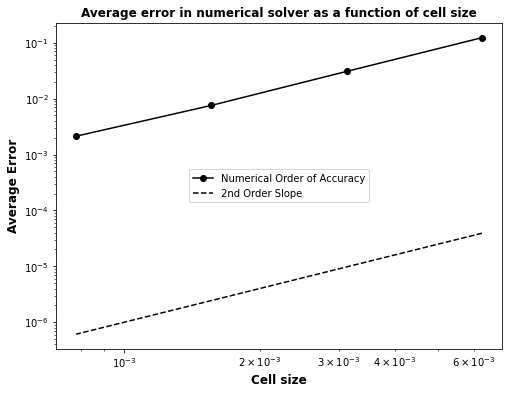

In [13]:
#cells =np.array((40**2, 80**2, 160**2, 320**2))
cells =np.array((Lx/Nx, (Lx/Nx)/2, (Lx/Nx)/4,(Lx/Nx)/8))
fig = plt.figure(figsize=(8,6))
plt.plot(cells,mse, color = 'k', marker = 'o')
plt.plot(cells,cells**2, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.title('Average error in numerical solver as a function of cell size', fontsize = 12, weight = 600)
plt.xlabel('Cell size', fontsize = 12, weight = 600)
plt.ylabel('Average Error', fontsize = 12, weight = 600)
plt.legend(['Numerical Order of Accuracy', '2nd Order Slope'],loc='center')
plt.savefig('2nd order convergence.png')

Inf_norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


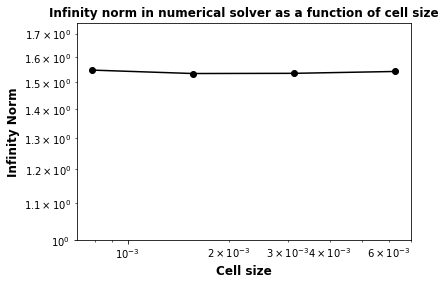

In [14]:
#cells =np.array((40**2, 80**2, 160**2, 320**2))
cells =np.array((Lx/Nx, (Lx/Nx)/2, (Lx/Nx)/4,(Lx/Nx)/8))
fig = plt.figure()
plt.plot(cells,inf_norm, color = 'k', marker = 'o')
plt.xscale('log')
plt.yscale('log')
plt.title('Infinity norm in numerical solver as a function of cell size', fontsize = 12, weight = 600)
plt.xlabel('Cell size', fontsize = 12, weight = 600)
plt.ylabel('Infinity Norm', fontsize = 12, weight = 600)
plt.axis([0, 0.007, 1, 1.75])
plt.savefig('inf_norm.png')

# Transient Heat Conduction

Plot transient heat conduction

In [15]:
# Function used to save the contour plot of temperature at set intervals
def savemyTempFieldImage(T, dx, dy, Lx, Ly, Nx, Ny, T_top, T_bottom, T_left, T_right, time,showPlot):
    # ----Reshaping matrices FOR PLOTTING-------------------------------------------------------------------------------
    v = np.arange(0, Lx, dx)
    w = np.arange(0, Ly, dy)
    T_plot = np.reshape(T, (Nx, Ny))

    # -----Plotting-----------------------------------------------------------------------------------------------------
    X, Y = np.meshgrid(v, w)
    fig, ax = plt.subplots()
#     CS = ax.contour(X, Y, T_plot)
    plt.title("Temperature Distribution  after 1,000,000 seconds", size=12)
    ax.set_xlabel('Lx (m)', rotation=0, size=12)
    ax.set_ylabel('Ly (m)', rotation=90, size=12)
    plt.contourf(X, Y, T_plot, cmap='inferno')
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel('Temperature (C)', rotation=270, size=12)
    imageName = 'Eoin' + str(time).zfill(6) + '.png'

    print('Saving ' + imageName)

    plt.savefig(imageName)

    if showPlot:
        plt.show()
    plt.close()

In [16]:
def FVTransientheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb,dt,total_time,rho,c):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #Calculate coefficients
    #east and west face coefficients equal i.e. along x direction
    ax = k*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = k*dx/dy
    
    alpha = -rho*c*dx*dy/dt
    ap = -2*(ax+ay)+alpha
    # total number of cells
    M = Nx*Ny
    M = int(M)

    
    # 3 coeffs on each corner + 4 coeffs on each cell attached to a side
    #+ 5 coeffs on each internal cell
    internalandcorner = 3*4+5*(Nx-2)*(Ny-2)
    sides =  4*(2*Nx+2*Ny-8)
    numNonZeros = internalandcorner+sides
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))

    
    #get indices of corner cells
    botright = Nx-1
    topleft = Nx*(Ny-1)
    topright = Nx*Ny-1
    Tmid = []
    #Loop through each cell i
    coeffi=0
    for i in range(0, M):
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay+alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
            
        #bottom right
        elif i == botright:
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay+alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
        #top left
        elif i == topleft:
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay+alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top right
        elif i == topright:
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay+alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -3*ay +alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top
        elif topleft < i < topright:
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -3*ay+alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficien
        #left
        elif i in range(Nx,topleft,Nx):
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -3*ax +alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        #right
        elif i in range(botright+Nx,topright,Nx):
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -3*ax +alpha
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
        else:
            #centre
            data[coeffi] = ap
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
    #create sparse coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(M, M))
    
    #Initialise temperature vector
    T = np.zeros((M))
    T=np.empty(M)
    T.fill(Tinitial)

    b = np.zeros(M)
    #TIME LOOP
    for t in range(0, int(total_time/dt)):  # time loop
        for i in range(0,M):
            #CORNERS
            #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
            if i == 0:
                #Source Vector
                b[i] = -2*ay*Tb-2*ax*Tl+alpha*T[i]


            #bottom right
            elif i == botright:
                #bottom right
                #Source Vector
                b[i] = -2*ay*Tb-2*ax*Tr+alpha*T[i]


            #top left
            elif i == topleft:
                #top left
                #Source Vector
                b[i] = -2*ay*Tt-2*ax*Tl+alpha*T[i]

            #top right
            elif i == topright:
                #top right
                #Source Vector
                b[i] = -2*ay*Tt-2*ax*Tr+alpha*T[i]

            #SIDES
            #bottom
            elif 0 < i < botright:
                #bottom
                #Source Vector
                b[i] = -2*ay*Tb+alpha*T[i]
            #top
            elif topleft < i < topright:
                #top
                #Source Vector
                b[i] = -2*ay*Tt+alpha*T[i]
            #left
            elif i in range(Nx,topleft,Nx):
                #left
                #Source Vector
                b[i] = -2*ax*Tl+alpha*T[i]

            #right
            elif i in range(botright+Nx,topright,Nx):
                #top
                #Source Vector
                b[i] = -2*ax*Tr+alpha*T[i]
            else:
                #internal
                #Source Vector
                b[i] = alpha*T[i]
                
        #Tmid is at centre of the plate used to calculate temporal accuracy and validate solver
        Tmid.append(T[int(topleft/2)+Nx])
        T = scipy.sparse.linalg.spsolve(A, b)
        if t == int(total_time/dt)-1:
             Tmid.append(T[int(topleft/2)+Nx])
#         print(t)
        
        if t % saveImageFreq == 0:
            savemyTempFieldImage(T, dx, dy, Lx, Ly, Nx, Ny, Tt, Tb, Tl, Tr,t, showPlot=True)
    
    return T, Tmid

## Test Transient Heat Conduction

In [17]:
#Define inputs

Lx = 1
Ly = 1
Nx = 200#when Nx and Ny = 164 the best convergence is achieved
Ny = 200
k = 45
Tl = 0
Tt = 70
Tr = 0
Tb = 0
Tinitial = 0
dt = 1e5

total_time = 10000
saveImageFreq = 100

rho = 8040
c = 490

T,Tmid250 = FVTransientheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb,dt,total_time,rho,c)



## Temporal Accuracy

Run simulation for various time steps and store value at centre of plate

Saving Eoin000000.png


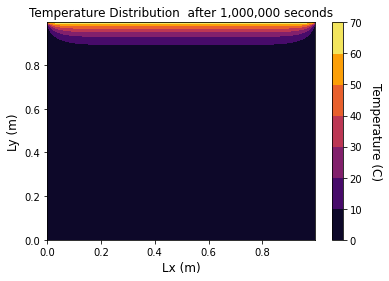

Saving Eoin000000.png


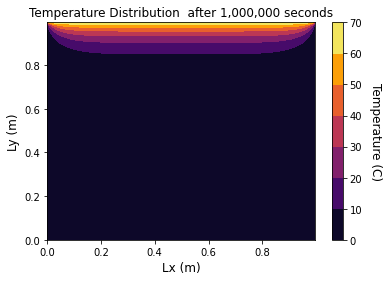

Saving Eoin000000.png


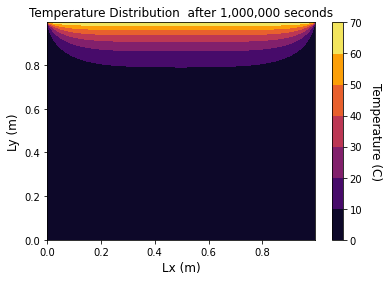

Saving Eoin000000.png


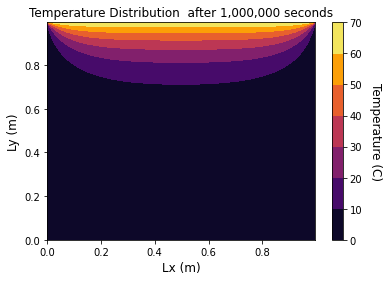

In [18]:
time_steps = [250,500,1000,2000]
Tmid = []
times = []
for dt in time_steps:
    _,Tmiddle = FVTransientheatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb,dt,total_time,rho,c)
    Tmid.append(Tmiddle)
    time = np.arange(0,total_time+dt,dt)
    times.append(time)

## Compare with Abaqus Results

Create dataframes of each run with time as index and Tmid as value

In [19]:
dfs = {}
for time,Tmiddle in zip(times,Tmid):
    
    dfs[time[1]] = pd.DataFrame(Tmiddle,index = time)

Combine all dataframes into one dataframe

In [20]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                            how='outer'), dfs.values()).fillna(np.nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [21]:
df_merged.columns = ['dt = 250', 'dt = 500', 'dt = 1000', 'dt = 2000']
# df_merged.rename(columns={'0_x': '1000', '0_y': '2000'}, inplace=True)
df_merged

,dt = 250,dt = 500,dt = 1000,dt = 2000
0,0.000000,0.000000,0.000000,0.000000
250,0.006302,NaN,NaN,NaN
500,0.035502,0.094193,NaN,NaN
750,0.110356,NaN,NaN,NaN
1000,0.251718,0.399864,0.618727,NaN
1250,0.472542,NaN,NaN,NaN
1500,0.776099,0.968822,NaN,NaN
1750,1.157412,NaN,NaN,NaN
2000,1.606041,1.776579,2.004340,2.236528
2250,2.108855,NaN,NaN,NaN


### INSERT PATH TO ABAQUS DATA FILE

In [24]:
file_path = '2d_heat_conduction_in_a_square_plate_abaqus_data.csv'

In [25]:
df_abaqus = pd.read_csv(file_path)

FileNotFoundError: ignored

In [ ]:
df_abaqus.set_index('Time ',inplace = True)
df_abaqus.rename(columns={'dt = 500 ': 'dt = 500'})

### Analyse temp at centre over time for each time step (plot on same graph)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14, 7))

df_abaqus.columns = df_abaqus.columns.str.replace(' ', '')
df_merged.columns = df_abaqus.columns.str.replace(' ', '')

ax[0].plot(df_merged['dt=250'],'k-')
ax[0].plot(df_merged['dt=500'],'k*',linewidth = 2)
ax[0].plot(df_merged['dt=1000'],'ko')
ax[0].plot(df_merged['dt=2000'],'k+')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Temperature (C)')
ax[0].set_title('Temperature at Centre of Plate vs Time (FVM)')
ax[0].legend(['dt=250','dt=500','dt=1000','dt=2000'] ,prop={'size': 13})
ax[1].plot(df_abaqus['dt=250'],'k-')
ax[1].plot(df_abaqus['dt=500'],'k*',linewidth = 2)
ax[1].plot(df_abaqus['dt=1000'],'ko')
ax[1].plot(df_abaqus['dt=2000'],'k+')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Temperature (C)')
ax[1].set_title('Temperature at Centre of Plate vs Time (Abaqus)')
ax[1].legend(['dt=250','dt=500','dt=1000','dt=2000'],prop={'size': 13})

plt.savefig('Tovertime.png')



### Analyse temperature at t = 4000 on log-log plot

In [ ]:
TFVM4k = df_merged.loc[df_merged.index==4000]
TAb4k = df_abaqus.loc[df_abaqus.index==4000]

# fig, ax =  plt.subplots(1,2,figsize=(14, 7))
time_steps = []
FVvalues = []
Abvalues = []
for col in TFVM4k.columns:
    dt = (int(col.split('=')[1]))
    valueFv = float(TFVM4k[col])
    valueAb = float(TAb4k[col])
    time_steps.append(dt)
    FVvalues.append(valueFv)
    Abvalues.append(valueAb)
    


In [ ]:
print(Abvalues)
print(FVvalues)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(time_steps,FVvalues,'k',marker = 'o')
ax.set_xscale('log')
ax.set_xlabel('Time step (dt)')
ax.set_ylabel('Temperature ')
ax.set_title('Temperature at Centre of Plate at t=400 at the different time steps')
plt.savefig('Tatdt.png')
